# Lhotse: Simplifying Speech Data Manipulation

_Piotr Żelasko_

## Introduction

In this post, we are introducing Lhotse - a speech data preparation library that aims to provide a flexible and expressive way to interact with audio recordings, while making it more approachable to a wider machine learning community.

Lhotse targets the audiences of speech, machine learning, deep learning and AI researchers and practitioners. The motivation behind Lhotse is for speech tooling to catch up with the computer vision (CV) and natural language processing (NLP) communities, which have recently developed many easy-to-use tools for advancing the state-of-the-art in these areas.

Lhotse can be installed using pip with `pip install lhotse`.

In [1]:
import lhotse

## Lhotse's data model

Lhotse provides three main abstractions that describe speech corpora. `RecordingSet`, that is used to describe the recordings; `SupervisionSet`, which describes the segments of interest (e.g. transcribed speech) and `CutSet`, which brings that information together and allows to manipulate the data. The first two are fairly simple objects that serve as data containers; the `CutSet`, on the other hand, is more interesting and enables various operations.

Each of these classes is serializable into JSON files.

### RecordingSet

`Recording`s hold the information about how to load a recording and some metadata, such as sampling rate or duration.

In [2]:
from lhotse import RecordingSet

recordings = RecordingSet.from_json('librispeech/data/mini_librispeech_nb/recordings_train-clean-5.json')

print(f'There are {len(recordings)} recordings.')
print(recordings['32-21631-0000'])

There are 1519 recordings.
Recording(id='32-21631-0000', sources=[AudioSource(type='file', channels=[0], source='data/LibriSpeech/train-clean-5/32/21631/32-21631-0000.flac')], sampling_rate=16000, num_samples=260000, duration=16.25)


In [3]:
# We're using "with_path_prefix" to adjust the relative paths in the manifest.
audio = recordings[0].with_path_prefix('librispeech/').load_audio()
print(type(audio), 'with shape', audio.shape)

<class 'numpy.ndarray'> with shape (1, 260000)


### SupervisionSet

Think of supervisions as speech segments. Supervisions hold information such as the transcript, speaker identity, language, and others. They may cover the whole recording when every utterance is held in a separate file; but for long recordings, e.g. conversations, there might be multiple supervisions in a single recording.

In [4]:
from lhotse import SupervisionSet

supervisions = SupervisionSet.from_json('librispeech/data/mini_librispeech_nb/supervisions_train-clean-5.json')

print(f'There are {len(supervisions)} recordings.')
print(supervisions['32-21631-0000'])

There are 1519 recordings.
SupervisionSegment(id='32-21631-0000', recording_id='32-21631-0000', start=0.0, duration=16.25, channel=0, text='AFTER MISTER CROW FLEW BACK TO PLEASANT VALLEY TO GATHER NEWS FOR HIM BROWNIE BEAVER CAREFULLY COUNTED EACH DAY THAT PASSED SINCE MISTER CROW HAD AGREED TO BE HIS NEWSPAPER AND COME EACH SATURDAY AFTERNOON TO TELL HIM EVERYTHING THAT HAD HAPPENED DURING THE WEEK', language='English', speaker='32', gender=None, custom=None)


### CutSet

We will demonstrate several capabilities of the `CutSet` below. The green area indicates an area covered by a supervision segment.

In [5]:
from lhotse import CutSet

cuts = CutSet.from_manifests(recordings, supervisions).with_recording_path_prefix('librispeech/')
cuts

CutSet(len=1519)

In [6]:
cut = cuts[0]
for item in (cut.id, cut.duration, cut.sampling_rate, cut.recording_id, cut.supervisions):
    print(item)

de9ae2f7-6258-4157-9cc5-26bbc7905d69
16.25
16000
32-21631-0000
[SupervisionSegment(id='32-21631-0000', recording_id='32-21631-0000', start=0.0, duration=16.25, channel=0, text='AFTER MISTER CROW FLEW BACK TO PLEASANT VALLEY TO GATHER NEWS FOR HIM BROWNIE BEAVER CAREFULLY COUNTED EACH DAY THAT PASSED SINCE MISTER CROW HAD AGREED TO BE HIS NEWSPAPER AND COME EACH SATURDAY AFTERNOON TO TELL HIM EVERYTHING THAT HAD HAPPENED DURING THE WEEK', language='English', speaker='32', gender=None, custom=None)]


Basic manipulation: truncating and padding, as well as visualization.

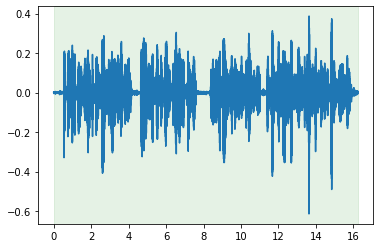

In [7]:
cut.plot_audio()

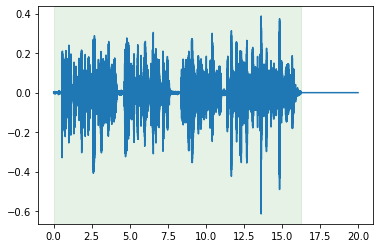

In [8]:
cut.pad(duration=20).plot_audio()

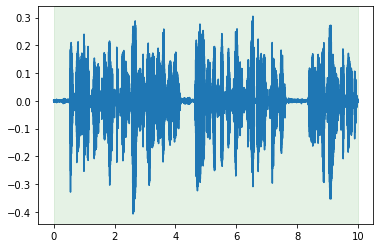

In [9]:
cut.truncate(duration=10).plot_audio()

More advanced operations: cut mixing.

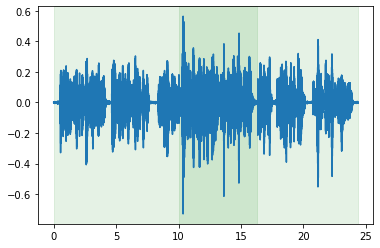

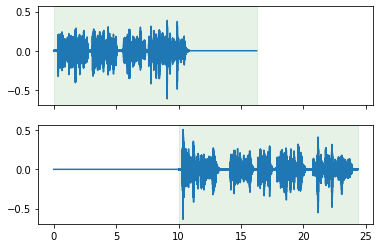

In [10]:
mixed = cut.mix(cuts[1], offset_other_by=10)
mixed.plot_audio()
mixed.plot_tracks_audio();

Mixing two cuts with a specified SNR.

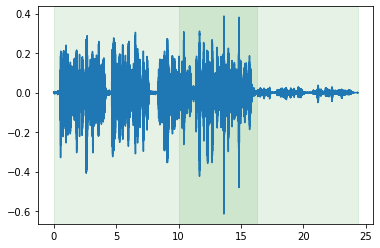

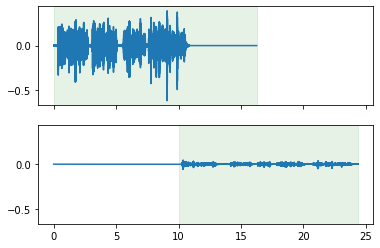

In [11]:
mixed = cuts[0].mix(cuts[1], offset_other_by=10, snr=20)
mixed.plot_audio()
mixed.plot_tracks_audio();

## Feature extraction

Lhotse provides Torchaudio integration for feature extraction, but can support other feature extraction libraries (or custom extractors) as well.

In the following example, we'll extract the log-Mel energy features. First, we'll show on-the-fly feature extraction

In [12]:
from lhotse import Fbank, FbankConfig

fbank = Fbank(config=FbankConfig(num_mel_bins=80))

for example_cut in (cut, cut.truncate(duration=5), cut.pad(duration=30)):
    feats = example_cut.compute_features(extractor=fbank)
    print(type(feats), 'with shape', feats.shape)

<class 'numpy.ndarray'> with shape (1625, 80)
<class 'numpy.ndarray'> with shape (500, 80)
<class 'numpy.ndarray'> with shape (3000, 80)


We can also choose to pre-compute and store the features somewhere, to load them later during training. We'll use a simple file-per-matrix backend for storage along with [lilcom](https://github.com/danpovey/lilcom/) lossy compression scheme for 3x smaller size. We also support HDF5, and will likely extend the support to other options in the future.

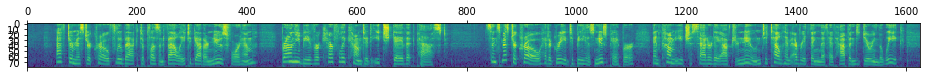

In [13]:
from lhotse import LilcomFilesWriter

# Note: It's possible, and recommended, to use "with LilcomFilesWriter() as storage:"
#       In this example we want to write several times, so we are doing it another way.
storage = LilcomFilesWriter('make_feats')
cut = cut.compute_and_store_features(extractor=fbank, storage=storage)

cut.plot_features()

With the feature extractors that support it, we can perform dynamic feature-domain mix, by pre-computing the features for individual cuts first, and mixing them in the feature domain once they are loaded into memory.

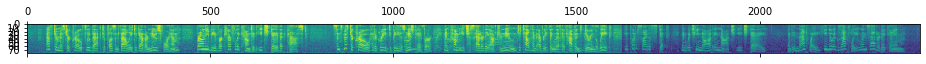

In [14]:
cut1 = cuts[1].compute_and_store_features(extractor=fbank, storage=storage)

# Note: the mix is performed only after the features were extracted.
mixed = cut.mix(cut1, offset_other_by=10, snr=20)
mixed.plot_features()

## PyTorch Datasets

While `CutSet` was a task-independent representation, we use PyTorch Dataset API to adapt it to a specific task.
Lhotse provides a number of "standard" task datasets to make its adoption easy. However, some applications will require more specialized approach - this is where Lhotse excels, as its utilities make it simpler to write a custom `Dataset` class in a concise way.

We'll first compute the features for the whole dataset using multiprocessing (it's also possible to use [Dask Client](https://docs.dask.org/en/latest/setup/single-distributed.html?highlight=Client#client) as a drop-in replacement).

In [15]:
from concurrent.futures import ProcessPoolExecutor

with ProcessPoolExecutor(4) as ex:
    cuts = cuts.compute_and_store_features(extractor=fbank, storage=storage, executor=ex).pad()

### K2 Speech Recognition

The following example illustrates [k2](https://github.com/k2-fsa/k2) speech recognition dataset.

In [16]:
from lhotse.dataset.speech_recognition import K2SpeechRecognitionDataset, K2DataLoader

dataset = K2SpeechRecognitionDataset(cuts)
dataset[0]

{'features': tensor([[-12.0000, -11.1406, -12.4326,  ...,  -6.7714,  -8.4343,  -8.6229],
         [-12.0312, -11.4487, -12.7315,  ...,  -7.7641,  -8.1930,  -8.2775],
         [-11.7805, -11.4454, -13.4272,  ...,  -8.1577,  -7.7074,  -7.6869],
         ...,
         [-99.9831, -99.9831, -99.9831,  ..., -99.9831, -99.9831, -99.9831],
         [-99.9831, -99.9831, -99.9831,  ..., -99.9831, -99.9831, -99.9831],
         [-99.9831, -99.9831, -99.9831,  ..., -99.9831, -99.9831, -99.9831]]),
 'supervisions': [{'sequence_idx': 0,
   'text': 'AFTER MISTER CROW FLEW BACK TO PLEASANT VALLEY TO GATHER NEWS FOR HIM BROWNIE BEAVER CAREFULLY COUNTED EACH DAY THAT PASSED SINCE MISTER CROW HAD AGREED TO BE HIS NEWSPAPER AND COME EACH SATURDAY AFTERNOON TO TELL HIM EVERYTHING THAT HAD HAPPENED DURING THE WEEK',
   'start_frame': 0,
   'num_frames': 1625}]}

In [17]:
dloader = K2DataLoader(dataset, batch_size=2, shuffle=True)
next(iter(dloader))

{'features': tensor([[[-11.8125, -11.5273, -12.8000,  ...,  -9.2881,  -9.3543,  -9.8999],
          [-14.3303, -14.4006, -15.2692,  ...,  -8.8515,  -9.7989,  -9.8018],
          [-12.8499, -11.9411, -12.4248,  ...,  -9.0515,  -9.9069,  -9.3730],
          ...,
          [-99.9831, -99.9831, -99.9831,  ..., -99.9831, -99.9831, -99.9831],
          [-99.9831, -99.9831, -99.9831,  ..., -99.9831, -99.9831, -99.9831],
          [-99.9831, -99.9831, -99.9831,  ..., -99.9831, -99.9831, -99.9831]],
 
         [[-14.5938, -13.9711, -14.9391,  ..., -10.3255, -11.0032, -10.7016],
          [-13.4852, -12.0677, -11.7995,  ..., -10.6782, -10.8621, -10.5152],
          [-12.5147, -11.6737, -13.8058,  ...,  -9.6783, -10.2814, -10.3619],
          ...,
          [-99.9831, -99.9831, -99.9831,  ..., -99.9831, -99.9831, -99.9831],
          [-99.9831, -99.9831, -99.9831,  ..., -99.9831, -99.9831, -99.9831],
          [-99.9831, -99.9831, -99.9831,  ..., -99.9831, -99.9831, -99.9831]]]),
 'supervisions':

### Other datasets

Lhotse implements several tasks already, and it will continue to support more with time. For example, text-to-speech dataset looks like the following (we don't show the values as the "tokens" list can be quite long). Note that it uses exactly the same data format as the ASR dataset thanks to Lhotse's `CutSet` universal representation.

In [18]:
from lhotse.dataset import SpeechSynthesisDataset

dataset = SpeechSynthesisDataset(cuts)
dataset[8].keys()

dict_keys(['audio', 'features', 'tokens'])

## Standard corpora recipes

Lhotse supports creation of Recording and Supervision manifests from raw speech corpora distributions, and helps in downloading them if they are publicly available. For example, `mini_librispeech`:

In [19]:
from lhotse.recipes.librispeech import download_and_untar, prepare_librispeech, dataset_parts_mini

download_and_untar('librispeech/data', dataset_parts=dataset_parts_mini)
libri = prepare_librispeech('librispeech/data/LibriSpeech', dataset_parts=dataset_parts_mini)
libri

defaultdict(dict,
            {'dev-clean-2': {'recordings': RecordingSet(len=1089),
              'supervisions': SupervisionSet(len=1089)},
             'train-clean-5': {'recordings': RecordingSet(len=1519),
              'supervisions': SupervisionSet(len=1519)}})

## Final words

This blog post showcased some of Lhotse's capabilities for speech data preparation. We did not discuss Lhotse's implementation details in depth, but focused more on its utility. Lhotse will continue to grow, and will serve as - but won't be limited to - the basis for K2 speech recognition recipes.

Interested in contributing? Don't ask what Lhotse can do for you, ask what you can do for Lhotse! Visit our GitHub and make a PR, raise an issue, or comment on some of the existing ones.

### Further reading

📝 Docs: https://lhotse.readthedocs.io/en/latest/

🔗 GitHub Repo: https://github.com/lhotse-speech/lhotse
